In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Question 3 ##
#### Question 3: Parts 1 & 2

In [164]:
# Water balance equation:
# Qt = Qp + Qe

# Tracer balance equations:
# Qe = Qt * (Ct - Cp)/(Ce - Cp)
# Qp = Qt * (Ce - Ct)/(Ce - Cp)

Qt = 10.0         # m^3/s total streamflow
Ct = -9.0         # ‰ stream δ18O
Ce = -5.0         # ‰ event water (rain) δ18O
Cp = -12.0        # ‰ pre-event water (groundwater) δ18O

Qe = Qt * (Ct - Cp) / (Ce - Cp)
Qp = Qt * (Ce - Ct) / (Ce - Cp)
# Qp = Qt - Qe

print(f"Part 1")
print(f"Qt Total streamflow:           {Qt:.2f} m^3/s")
print(f"Qp Pre-event water discharge:  {Qp:.2f} m^3/s")
print(f"Qe Event water discharge:      {Qe:.2f} m^3/s\n")

print(f"Part 2")
if Qe > Qp:
    print(f"Dominant component: Event water (Rainfall)")
else:
    print(f"Dominant component: Pre-Event water (Groundwater)")


Part 1
Qt Total streamflow:           10.00 m^3/s
Qp Pre-event water discharge:  5.71 m^3/s
Qe Event water discharge:      4.29 m^3/s

Part 2
Dominant component: Pre-Event water (Groundwater)


## Question 4
#### Question 4: Part 1a

In [165]:
# Calculate fractions of each source at each sample time and plot a figure that: shows event water fraction vs. time

# Endmembers (Table 1)
endmembers = {
    "event_rain": {"d18O": -4.0, "Si": 1.0},
    "soil":       {"d18O": -8.0, "Si": 8.0},
    "gw":         {"d18O": -11.0,"Si": 20.0},
}

# Observations (Table 2)   
data = pd.DataFrame({
    "time_hr": [0, 2, 4, 6, 10, 16, 24],
    "Qt_m3s":  [2.0, 4.5, 9.0, 12.0, 7.0, 4.0, 2.5],            # Streamflow
    "d18O_t":  [-11.0, -9.5, -8.5, -7.8, -8.8, -9.8, -10.5],    # δ18O ‰
    "Si_t":    [18, 15, 12, 10, 13, 16, 17],                    # Silica mg/L
})


# Calculate fractions of each source at each sample time and plot a figure that shows event water fraction vs time
A = np.array([
    [1.0, 1.0, 1.0],
    [endmembers["event_rain"]["Si"],  endmembers["soil"]["Si"],  endmembers["gw"]["Si"]],
    [endmembers["event_rain"]["d18O"],endmembers["soil"]["d18O"],endmembers["gw"]["d18O"]],
], dtype=float)

fractions = []
for _, row in data.iterrows():                                      # Loop through each row of the storm time series
    b = np.array([1.0, row["Si_t"], row["d18O_t"]], dtype=float)    # Build vector 'b' (right side of equation)
    f_event, f_soil, f_gw = np.linalg.solve(A, b)                   # Solve for the fractions at that time
    fractions.append((f_event, f_soil, f_gw))                       # Store fractions in the list

data[["f_event", "f_soil", "f_gw"]] = pd.DataFrame(fractions, index=data.index)     #Update data DataFrame

# Convert fractions to component discharges
data["Q_event"] = data["f_event"] * data["Qt_m3s"]
data["Q_soil"]  = data["f_soil"]  * data["Qt_m3s"]
data["Q_gw"]    = data["f_gw"]    * data["Qt_m3s"]

# Check mass balance
data["f_sum"] = data["f_event"] + data["f_soil"] + data["f_gw"]
data[["time_hr","f_sum"]]

# Check mass balance
data["f_sum"] = data["f_event"] + data["f_soil"] + data["f_gw"]
data[["time_hr","f_sum"]]

# Flag points where fraction is negative or greater than 1 (located outside triangle)
def flag_row(row):
    f = np.array([row["f_event"], row["f_soil"], row["f_gw"]])
    return (f < -1e-8).any() or (f > 1+1e-8).any()

data["Outside Triangle"] = data.apply(flag_row, axis=1)
data[["time_hr","f_event","f_soil","f_gw","Outside Triangle"]]

,time_hr,f_event,f_soil,f_gw,Outside Triangle
0,0,-0.222222,0.518519,0.703704,True
1,2,0.111111,0.240741,0.648148,False
2,4,0.222222,0.314815,0.462963,False
3,6,0.311111,0.340741,0.348148,False
4,10,0.200000,0.266667,0.533333,False
5,16,0.088889,0.192593,0.718519,False
6,24,-0.111111,0.425926,0.685185,True


#### Question 4: Part 1b

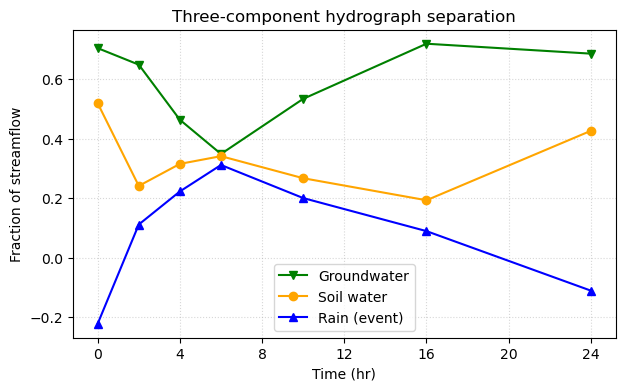

In [ ]:
# Plot a figure that shows event water fraction vs time

plt.figure(figsize=(7,4))
plt.plot(data["time_hr"], data["f_gw"], color="green", marker="v", label="Groundwater")
plt.plot(data["time_hr"], data["f_soil"], color="orange", marker="o", label="Soil water")
plt.plot(data["time_hr"], data["f_event"], color="blue", marker="^", label="Rain (event)")

xmin = 0
xmax = data["time_hr"].max()
plt.xticks(np.arange(xmin, xmax + 4, 4))
plt.xlabel("Time (hr)")
plt.ylabel("Fraction of streamflow")
plt.title("Water fraction vs time")
plt.grid(True, which="major", axis="both", linestyle=":", alpha=0.5)
plt.legend()
plt.grid(True)
plt.show()

## Question 5

In [167]:
# Use two tracers (δD and Cl-) to estimate the fraction of throughfall, soil water, and groundwater in this streamflow.
endmembers = {
    "throughfall": {"dD": -53.0, "d18O": -8.30, "Cl": 6.98, "Na": 0.39},    # Units: ‰, ‰, µmol/L, µmol/L 
    "soil":        {"dD": -38.5, "d18O": -6.35, "Cl": 10.1, "Na": 5.81},    
    "gw":          {"dD": -47.0, "d18O": -7.97, "Cl": 35.6, "Na": 30.3},
}


stream = {"dD": -49.0, "d18O": -7.90, "Cl": 21.2, "Na": 17.6}


def three_component_fractions(endmembers, stream, tracer1, tracer2, order=("throughfall","soil","gw")):
    A = np.array([
        [1.0, 1.0, 1.0],
        [endmembers[order[0]][tracer1], endmembers[order[1]][tracer1], endmembers[order[2]][tracer1]],
        [endmembers[order[0]][tracer2], endmembers[order[1]][tracer2], endmembers[order[2]][tracer2]],
    ], dtype=float)

    b = np.array([1.0, stream[tracer1], stream[tracer2]])
    f = np.linalg.solve(A, b) 
    return pd.Series(f, index=list(order))


def inside_mixing_triangle(fracs, tol=1e-10):
    return (fracs >= -tol).all() and (fracs <= 1+tol).all()


def print_result(label, fracs):
    print(f"\n{label}")
    print(fracs.round(4))
    print(f"Sum = {fracs.sum():.4f}")
    print("Inside mixing triangle?", inside_mixing_triangle(fracs))


def plot_mixing_diagram(endmembers, stream, xtracer, ytracer, title):
    xs = [endmembers[k][xtracer] for k in ["throughfall","soil","gw"]]
    ys = [endmembers[k][ytracer] for k in ["throughfall","soil","gw"]]

    plt.figure(figsize=(8,8))
    plt.plot(xs + [xs[0]], ys + [ys[0]], color="darkgrey", linestyle=":", zorder=1)
    plt.scatter(xs, ys, marker="s", color="darkred", zorder=2)
    for k in ["throughfall","soil","gw"]:
        plt.text(endmembers[k][xtracer], endmembers[k][ytracer], f" {k.capitalize()}")

    plt.scatter([stream[xtracer]], [stream[ytracer]], marker="*", color="blue")
    plt.text(stream[xtracer], stream[ytracer], " Stream Peak")

    plt.xlabel(f"{xtracer}")
    plt.ylabel(f"{ytracer}")
    plt.title(title)
    plt.grid(True, alpha=0.15)
    plt.tight_layout()
    plt.show()

#### Question 5: Parts 1 & 2a


Fractions at peak using δD and Cl
throughfall    0.4376
soil           0.0736
gw             0.4888
dtype: float64
Sum = 1.0000
Inside mixing triangle? True


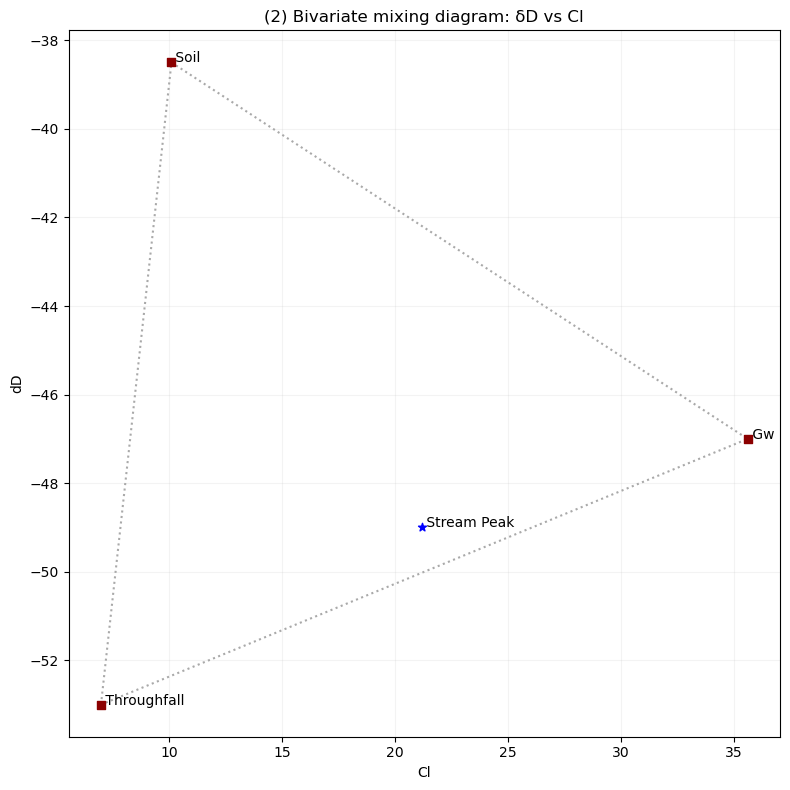

In [168]:
fracs_dD_Cl = three_component_fractions(endmembers, stream, tracer1="Cl", tracer2="dD")
print_result("Fractions at peak using δD and Cl", fracs_dD_Cl)
plot_mixing_diagram(endmembers, stream, xtracer="Cl", ytracer="dD", title="(2) Bivariate mixing diagram: δD vs Cl")

#### Question 5: Part 3


Fractions using δ18O and Cl
throughfall    0.3933
soil           0.1233
gw             0.4834
dtype: float64
Sum = 1.0000
Inside mixing triangle? True


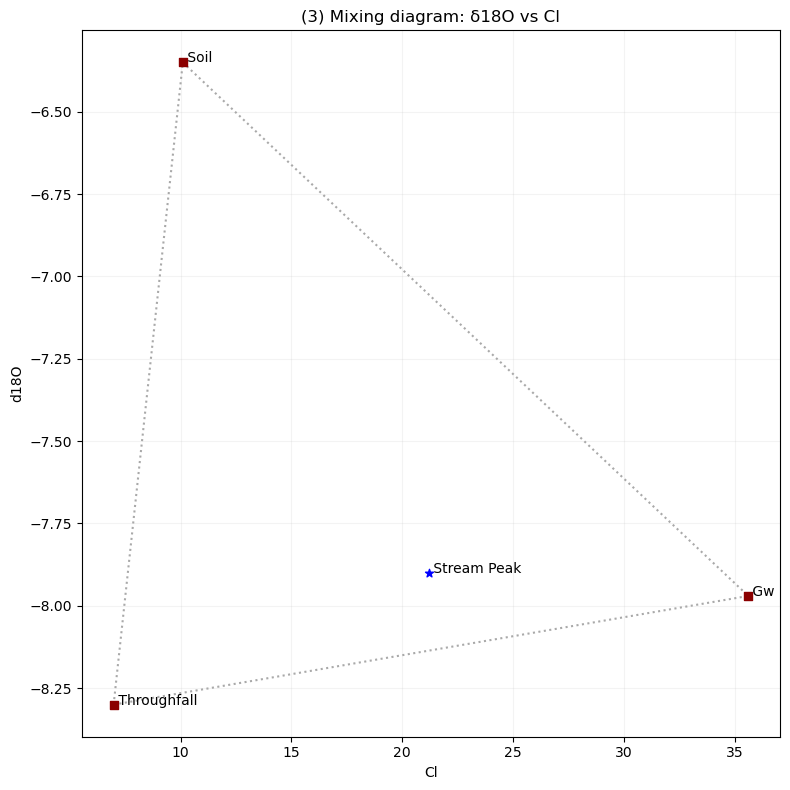

In [169]:
fracs_d18O_Cl = three_component_fractions(endmembers, stream, tracer1="Cl", tracer2="d18O")
print_result("Fractions using δ18O and Cl", fracs_d18O_Cl,)
plot_mixing_diagram(endmembers, stream, xtracer="Cl", ytracer="d18O", title="(3) Mixing diagram: δ18O vs Cl")

#### Question 5: Part 4


Fractions using δD and Na
throughfall    0.3912
soil           0.0408
gw             0.5680
dtype: float64
Sum = 1.0000
Inside mixing triangle? True


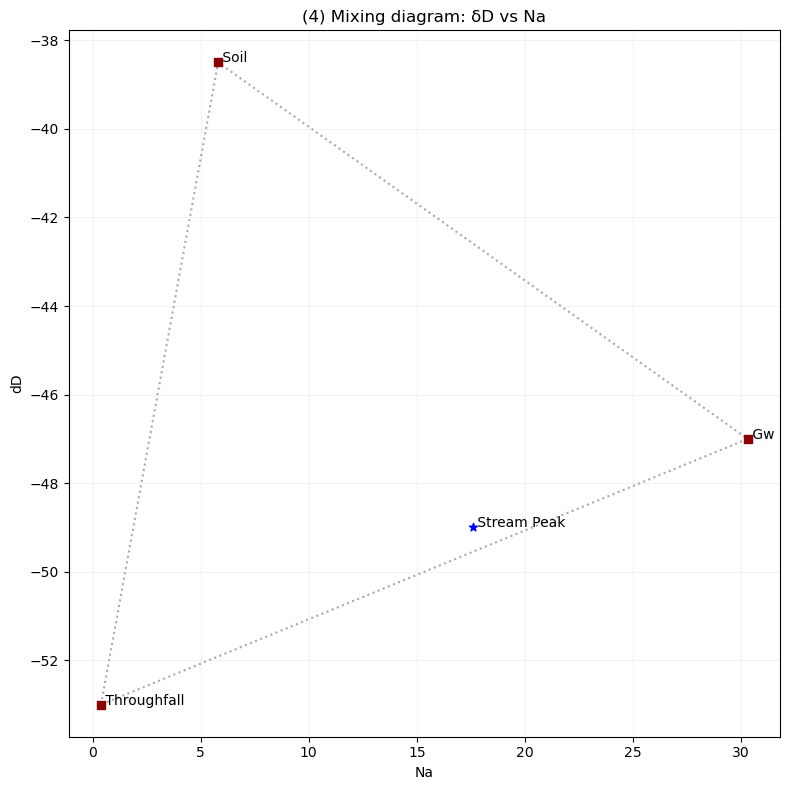

In [170]:
fracs_dD_Na = three_component_fractions(endmembers, stream, tracer1="Na", tracer2="dD")
print_result("Fractions using δD and Na", fracs_dD_Na)
plot_mixing_diagram(endmembers, stream, xtracer="Na", ytracer="dD",title="(4) Mixing diagram: δD vs Na")

#### Question 5: Part 5

In [171]:
# Table of endmembers and calculated mixing fractions
results = pd.DataFrame({
    "δD + Cl":   fracs_dD_Cl,
    "δ18O + Cl": fracs_d18O_Cl,
    "δD + Na":   fracs_dD_Na,
})
results.loc["Dominant Source"] = results.idxmax(axis=0)
results

,δD + Cl,δ18O + Cl,δD + Na
throughfall,0.43758,0.393268,0.391176
soil,0.073586,0.12332,0.04083
gw,0.488833,0.483412,0.567994
Dominant Source,gw,gw,gw
